<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_branching_jjiam/blob/main/multidimensional_burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.13.1+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Tue Apr 11 10:08:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:21:00.0  On |                  Off |
| 41%   39C    P5    30W / 140W |   1226MiB / 16376MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

In [5]:
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return ( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) 
    
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return (( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) + dim * dim * y[(dim+1):(2*dim+1)].sum(dim=0) / 2 )

def phi_example(x, coordinate=0):
    return torch.exp( T + x.sum(axis=0) / dim ) / (1 + torch.exp( T + x.sum(axis=0) / dim ) )
        
def exact_example(t, x, T):
    xi = t + x.sum(axis=0) / dim 
    return 1 / (1 + np.exp( - xi ) )

t_lo, x_lo, x_hi = 0., -5., 5.
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

### Figure 2-a) with d=5 and T = 0.2

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 157 seconds; L1 error: 5.23E-03; L2 error: 5.07E-05; rel error: 1.32E-02.
fdb runtime: 14 seconds; total runtime: 172 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 184 seconds; L1 error: 5.49E-04; L2 error: 5.62E-07; rel error: 1.47E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 142 seconds; L1 error: 5.68E-03; L2 error: 4.13E-05; rel error: 1.35E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 162 seconds; L1 error: 6.74E-03; L2 error: 5.85E-05; rel error: 1.57E-02.
fdb runtime: 20 seconds; total runtime: 183 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 179 seconds; L1 error: 7.39E-04; L2 error: 7.69E-07; rel error: 1.81E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 148 seconds; L1 error: 5.21E-03; L2 error: 3.69E-05; rel error: 1.24E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 132 seconds; L1 error: 6.38E-03; L2 error: 5.63E-05; rel error: 1.41E-02.
fdb runtime: 16 seconds; total runtime: 147 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 174 seconds; L1 error: 1.06E-03; L2 error: 1.88E-06; rel error: 2.69E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 145 seconds; L1 error: 4.55E-03; L2 error: 3.11E-05; rel error: 1.16E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 134 seconds; L1 error: 6.65E-03; L2 error: 6.42E-05; rel error: 1.67E-02.
fdb runtime: 21 seconds; total runtime: 155 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 175 seconds; L1 error: 7.03E-04; L2 error: 6.44E-07; rel error: 1.35E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 148 seconds; L1 error: 5.01E-03; L2 error: 3.18E-05; rel error: 1.21E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 131 seconds; L1 error: 4.98E-03; L2 error: 3.63E-05; rel error: 1.18E-02.
fdb runtime: 17 seconds; total runtime: 148 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 138 seconds; L1 error: 7.31E-04; L2 error: 8.24E-07; rel error: 1.77E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 131 seconds; L1 error: 4.09E-03; L2 error: 2.63E-05; rel error: 1.02E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 109 seconds; L1 error: 3.97E-03; L2 error: 2.52E-05; rel error: 8.61E-03.
fdb runtime: 14 seconds; total runtime: 123 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 142 seconds; L1 error: 9.58E-04; L2 error: 2.41E-06; rel error: 1.62E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 133 seconds; L1 error: 4.51E-03; L2 error: 3.04E-05; rel error: 1.13E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 109 seconds; L1 error: 7.51E-03; L2 error: 7.98E-05; rel error: 1.89E-02.
fdb runtime: 18 seconds; total runtime: 127 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 141 seconds; L1 error: 1.47E-03; L2 error: 3.04E-06; rel error: 3.69E-03.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 129 seconds; L1 error: 3.63E-03; L2 error: 1.62E-05; rel error: 8.17E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 110 seconds; L1 error: 6.97E-03; L2 error: 6.95E-05; rel error: 1.72E-02.
fdb runtime: 31 seconds; total runtime: 141 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 138 seconds; L1 error: 1.61E-03; L2 error: 3.37E-06; rel error: 3.23E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 130 seconds; L1 error: 4.64E-03; L2 error: 3.32E-05; rel error: 1.19E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 105 seconds; L1 error: 6.61E-03; L2 error: 5.63E-05; rel error: 1.58E-02.
fdb runtime: 21 seconds; total runtime: 126 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 141 seconds; L1 error: 6.87E-04; L2 error: 6.61E-07; rel error: 1.70E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 130 seconds; L1 error: 4.79E-03; L2 error: 2.95E-05; rel error: 1.12E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 107 seconds; L1 error: 5.96E-03; L2 error: 5.06E-05; rel error: 1.49E-02.
fdb runtime: 21 seconds; total runtime: 128 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 140 seconds; L1 error: 1.72E-03; L2 error: 4.51E-06; rel error: 4.45E-03.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 134 seconds; L1 error: 4.45E-03; L2 error: 2.49E-05; rel error: 1.02E-02.




######## Summary for deep branching method
runtime:        126
fdb runtime:    19
total runtime:  145
mean L1 error:  6.10E-03
std L1 error:   1.02E-03
mean L2 error:  5.47E-05
std L2 error:   1.48E-05
mean rel error: 1.47E-02
std rel error:  2.80E-03


######## Summary for deep galerkin method
runtime:        155
mean L1 error:  1.02E-03
std L1 error:   4.04E-04
mean L2 error:  1.87E-06
std L2 error:   1.34E-06
mean rel error: 2.38E-03
std rel error:  1.02E-03


######## Summary for deep BSDE method
runtime:        137
mean L1 error:  4.66E-03
st

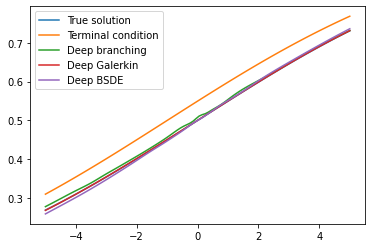

In [9]:
T = 0.2
dim = 5
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=3000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

### Figure 2-b) with d=10 and T = 0.1

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 238 seconds; L1 error: 5.12E-03; L2 error: 5.12E-05; rel error: 1.07E-02.
fdb runtime: 2776 seconds; total runtime: 3014 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 624 seconds; L1 error: 3.47E-02; L2 error: 1.72E-03; rel error: 7.23E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 143 seconds; L1 error: 4.05E+00; L2 error: 2.31E+01; rel error: 7.86E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 253 seconds; L1 error: 1.06E-02; L2 error: 2.04E-04; rel error: 2.11E-02.
fdb runtime: 2703 seconds; total runtime: 2956 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 589 seconds; L1 error: 3.39E-02; L2 error: 1.63E-03; rel error: 7.05E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 144 seconds; L1 error: 8.93E+00; L2 error: 9.74E+01; rel error: 1.76E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 227 seconds; L1 error: 7.27E-03; L2 error: 1.08E-04; rel error: 1.49E-02.
fdb runtime: 2069 seconds; total runtime: 2296 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 597 seconds; L1 error: 3.39E-02; L2 error: 1.63E-03; rel error: 7.06E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 1.41E+01; L2 error: 2.03E+02; rel error: 2.84E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 228 seconds; L1 error: 9.01E-03; L2 error: 1.20E-04; rel error: 1.87E-02.
fdb runtime: 2133 seconds; total runtime: 2360 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 559 seconds; L1 error: 3.46E-02; L2 error: 1.71E-03; rel error: 7.21E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 144 seconds; L1 error: 2.72E+00; L2 error: 9.64E+00; rel error: 5.35E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 281 seconds; L1 error: 8.72E-03; L2 error: 1.38E-04; rel error: 1.73E-02.
fdb runtime: 4940 seconds; total runtime: 5221 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 598 seconds; L1 error: 3.52E-02; L2 error: 1.79E-03; rel error: 7.35E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 150 seconds; L1 error: 1.87E+01; L2 error: 3.89E+02; rel error: 3.84E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 211 seconds; L1 error: 8.00E-03; L2 error: 1.40E-04; rel error: 1.63E-02.
fdb runtime: 1865 seconds; total runtime: 2076 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 594 seconds; L1 error: 3.56E-02; L2 error: 1.82E-03; rel error: 7.43E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 150 seconds; L1 error: 3.29E+00; L2 error: 1.30E+01; rel error: 6.78E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 249 seconds; L1 error: 8.75E-03; L2 error: 1.19E-04; rel error: 1.81E-02.
fdb runtime: 2883 seconds; total runtime: 3132 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 603 seconds; L1 error: 3.13E-02; L2 error: 1.33E-03; rel error: 6.43E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 149 seconds; L1 error: 3.87E+00; L2 error: 1.61E+01; rel error: 7.73E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 255 seconds; L1 error: 4.09E-03; L2 error: 2.55E-05; rel error: 8.26E-03.
fdb runtime: 2843 seconds; total runtime: 3098 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 600 seconds; L1 error: 3.09E-02; L2 error: 1.27E-03; rel error: 6.26E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 146 seconds; L1 error: 4.06E+00; L2 error: 1.78E+01; rel error: 8.21E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 229 seconds; L1 error: 7.23E-03; L2 error: 1.16E-04; rel error: 1.48E-02.
fdb runtime: 1553 seconds; total runtime: 1783 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 606 seconds; L1 error: 3.53E-02; L2 error: 1.81E-03; rel error: 7.39E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 140 seconds; L1 error: 1.14E+00; L2 error: 1.70E+00; rel error: 2.27E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/burgers/deep_branching_burgers/notebooks/logs/tmp


Time taken: 243 seconds; L1 error: 5.71E-03; L2 error: 4.67E-05; rel error: 1.17E-02.
fdb runtime: 2227 seconds; total runtime: 2470 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 611 seconds; L1 error: 3.51E-02; L2 error: 1.76E-03; rel error: 7.31E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 142 seconds; L1 error: 7.56E+00; L2 error: 6.07E+01; rel error: 1.52E+01.




######## Summary for deep branching method
runtime:        241
fdb runtime:    2599
total runtime:  2841
mean L1 error:  7.45E-03
std L1 error:   1.89E-03
mean L2 error:  1.07E-04
std L2 error:   5.02E-05
mean rel error: 1.52E-02
std rel error:  3.76E-03


######## Summary for deep galerkin method
runtime:        598
mean L1 error:  3.41E-02
std L1 error:   1.56E-03
mean L2 error:  1.65E-03
std L2 error:   1.84E-04
mean rel error: 7.07E-02
std rel error:  3.86E-03


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  6.84E

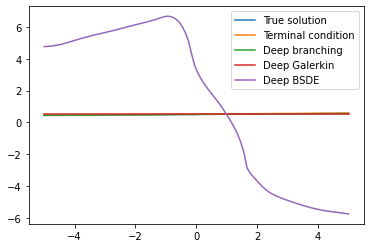

In [12]:
T = 0.1
dim = 20
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)